## Natural Language Processing (NLP)

### Import Data
First of all we need some data to work with. For this propose we can use the [public SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) on machine learning repository of UCI.

After downloding and unzipping the data, there would be two files:
- readme file including the information about the data Set
- SMSSpamCollection file which contains the data

In summary, the data contains more than 5000 messages that have been collected for SMS Spam research (4,827 SMS legitimate messages (86.6%) and a total of 747 (13.4%) spam messages).

The files contain one message per line. Each line is composed by two columns: one with label (ham or spam) and other with the raw text. 

In [6]:
# Import messages from file
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

# Show the first 10 messages
for num, message in enumerate(messages[:10]):
    print(num, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, آ£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea آ£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

As you can see in the print above, this is a TSV (_Tab Separated Values_) file and secondly messages have labels _ham_ and _spam_, which corresponds to _normal_ and _spam_ messages, respectively.

In the continue the main goal of this article is to setup a machine learning model to identify _ham_ and _spam_ messages itself. It would be a supervised method and we will use some part of the messages for the training process. 

But before that, we will do some analysis on the messages. For convenience 

In [7]:
# import pandas library
import pandas as pd 

df_messages = pd.read_csv('smsspamcollection/SMSSpamCollection',
                        sep='\t', names=['label','message'])

In [8]:
# Check the dataframe
df_messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


As you can see, there are 5572 messages in our dataframe. First of all we extract some general information from the data:

In [9]:
# Some general info of the messages dataframe
df_messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Based on the description, there are 2 unique labels, ham and spam. Ham is the more frequent label which repeated 4825 times. Almost, all of the messages were different and the top repeated message were _"Sorry, I'll call later"_, which repeated 30 times. 

We can extract info of each label separately to have more detailed informaiton:     

In [10]:
df_messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

So here we can find out more details on each of the labels. In the next step we'll extract some features of the messages, like length etc, and add them to the dataframe.

In [12]:
# Extract and add length of each message to the dataframe
df_messages['length'] = df_messages['message'].apply(len)

# Check the dataframe
df_messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


It would be nice of we add some visualization.

In [13]:
import matplotlib.pyplot as plt 
import seaborn as sns 

<AxesSubplot:xlabel='length', ylabel='Count'>

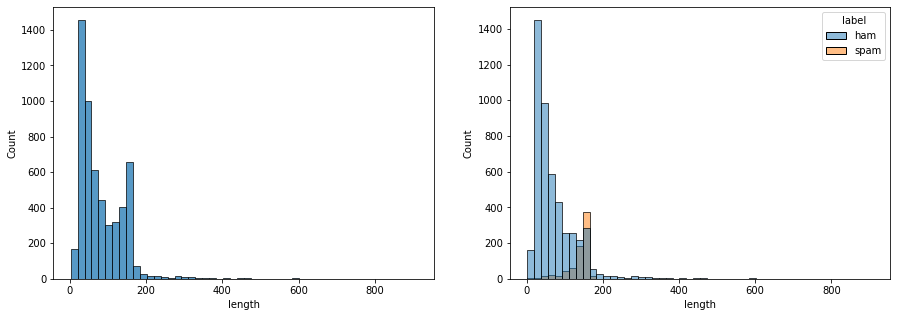

In [40]:
# plot histogram of the length of messages
# + also for labels separately

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df_messages, x='length', bins = 50, ax=axes[0])
sns.histplot(df_messages, x='length', hue='label', bins = 50, ax=axes[1])